<!--
SPDX-FileCopyrightText: Copyright (c) 2024 Idiap Research Institute <contact@idiap.ch>
SPDX-FileContributor: Alina Elena Baia <alina.baia.idiap.ch>
SPDX-FileContributor: Darya Baranouskaya <darya.baranouskaya.idiap.ch>
SPDX-FileContributor: Olena Hrynenko <olena.hrynenko.idiap.ch>
-->

# Practice exercises after Lecture 6
This notebook contains the practice exercise with instructions and explanations.

Work through the cells below in sequential order, executing each cell as you progress. Throughout the notebook, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you will also find questions. Try to reflect on the questions before/after running the code.


This notebook was developped at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch), [Roberto Boghetti](mailto:roberto.boghetti@idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution).

The code of this notebooks has been taked and adapted from official tutorials on [PyTorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html), which are available under MIT Copyright (c) 2023 PyG Team <team@pyg.org> licence.



The **aim** of the exercises is to:

**6.1** Get familiar with [PyTorch geometric (PyG)](https://pytorch-geometric.readthedocs.io/en/latest/): how to load datasets, view information about the graphs

**6.2** Understand [message passing framework](https://doi.org/10.48550/arXiv.1704.01212) in Graph Neural Networks (GNNs)

**6.3** Implement Graph convolutional network (GCN) on the [PROTEINS](https://www.researchgate.net/profile/Cheng-Soon-Ong/publication/7782805_Protein_Function_Prediction_via_Graph_Kernels/links/09e41507e5184631f4000000/Protein-Function-Prediction-via-Graph-Kernels.pdf) dataset for a graphs classification task.

---



#####**6.1 Getting familiar with PyTorch geometric (PyG)**

We will be using PyTorch Geometric library for this exercise. "PyG (PyTorch Geometric) is a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data." [(reference)](https://pytorch-geometric.readthedocs.io/en/latest/)

In [1]:
import getpass
import os
import re
import torch

# For efficient usage of the hardware resources when running on JupyterHub EPFL,
# we will limit the number of threads. If you are running this code on your local
# machine or on colab, the following code will not do anything.
# piece of code were adopted from the notebooks developed at the Idiap Research Institute by Olivier Canévet.

if re.search('^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:
    num_threads_limit = 2
else:
    num_threads_limit = torch.get_num_threads()
print(f"Limiting the number of threads to {num_threads_limit}")
torch.set_num_threads(num_threads_limit)
print(f"PyTorch is using {torch.get_num_threads()} threads")

_ = torch.set_flush_denormal(True) # To avoid long training time on CPU

Limiting the number of threads to 4
PyTorch is using 4 threads


If you are using Noto to run this notebook, follow the instructions below to install install the packages necessary for the exercise:

1) open a terminal and activate your virtual environment with the following command (instructions on how to create a virtual environment are available [here](https://moodle.epfl.ch/mod/forum/discuss.php?d=99699))

```
my_venvs_activate name_of_your_environment
```
2) get the torch version: after activating your virtual environment, open Python in interactive mode with the following command:
```
python
```
then, in Python interactive mode import torch and print the torch version using the following code:
```
import torch
print(torch.__version__)
```
You will get something like this: 2.0.1+cu117

3) Install the packages using the command below. Make sure to replace ${TORCH} with your torch version.
```
pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

```
If your torch version is 2.0.1+cu117 the installation commands will be:
```
pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
```

4) finally, restart your kernel from the Noto interface: Kernel-> Restart Kernel


If you are runing this notebook on Google Colab you can run the following cell to install the packages necessary for the exercise.


In [2]:
# taken from MIT Copyright (c) 2023 PyG Team

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121


######**How can we represent a graph?**

A graph $\mathcal{G}$ consist of a set nodes/verticies $\mathcal{V}$ and the edges $\mathcal{E}$ that connect them: $\mathcal{G} = (\mathcal{V}, \mathcal{E})$.

One of the ways of representing graphs is by having a set of nodes $\mathcal{V}$, and a corresponding adjacency matrix $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$. In this matrix $a_{ij} = 1$ if there exists an edge that has $v_1$ node as a source and $v_2$ as a target, and $a_{ij} = 0$ otherwise.

While storing information about edges in a matrix form (i.e., $\mathbf{A}$) is a convenient mathematical notation, there is one issue: quite often big graphs are sparce, hence a big adjacency matrix would in reality contain only very little non-zero entries.

Hence, there is an alternative way of writing the graph information, which is called coordinate format ([COO format](https://pytorch.org/docs/stable/sparse.html#sparse-coo-docs)). "Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero."
([reference](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=kVARD8kstxAY))


######**How to load and to view the dataset?**

PyG has a collection of the graph datasets available, which is accessible via this [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage. If you want to upload your custom dataset with graphs, you can check [official documentation](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html) for more information.

Let's now see how PyG stores the information about the datasets, using the following datasets as examples:

*   [Zachary’s karate club](https://www.jstor.org/stable/pdf/3629752.pdf?casa_token=TOIWobNuTZYAAAAA:eHXH2WW93OILyPaJhkHWBzP8nKanLeo1SSn-bCe2DTS9gF2JM1nnbEdQawrx3beKYnxlDCfu_vx0RjYKsMog3yV9kOztpMMVdBWeKXbgMg6Zg86oNyIf0g) dataset
*   [PROTEINS](https://www.researchgate.net/profile/Cheng-Soon-Ong/publication/7782805_Protein_Function_Prediction_via_Graph_Kernels/links/09e41507e5184631f4000000/Protein-Function-Prediction-via-Graph-Kernels.pdf) dataset

**KarateClub** dataset

"Zachary’s karate club network from the “An Information Flow Model for Conflict and Fission in Small Groups” paper, containing 34 nodes, connected by 156 (undirected and unweighted) edges. Every node is labeled by one of four classes obtained via modularity-based clustering, following the “Semi-supervised Classification with Graph Convolutional Networks” paper. Training is based on a single labeled example per class, i.e. a total number of 4 labeled nodes." [(reference)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.KarateClub.html)

In [3]:
# adopted from MIT Copyright (c) 2023 PyG Team

def diplay_dataset_info(dataset):
    """
    Displays basic information about the dataset with graphs.

    Args:
        dataset: dataset from torch_geometric.datasets
    Returns:
        None: This function does not return a value.
    """
    print(f'Information about {dataset} dataset:')
    print(f'    Number of graphs: {len(dataset)}')
    print(f'    Number of features: {dataset.num_features}')
    print(f'    Number of classes: {dataset.num_classes}')
    print()

def display_graph_info(dataset, graph_index):
    """
    Displays basic information about the graph with  with graphs.

    Args:
        dataset: dataset from torch_geometric.datasets
    Returns:
        None: This function does not return a value.
    """
    graph = dataset[graph_index]
    print(f'Information about graph #{graph_index} from {dataset} dataset:')
    print(f'    Number of nodes: {graph.num_nodes}')
    print(f'    Number of edges: {graph.num_edges}')
    print(f'    Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
    print(f'    Has isolated nodes: {graph.has_isolated_nodes()}')
    print(f'    Has self-loops: {graph.has_self_loops()}')
    print(f'    Is undirected: {graph.is_undirected()}')
    print()

In [4]:
from torch_geometric.datasets import KarateClub
karate_dataset = KarateClub()

#displaying information about the dataset
diplay_dataset_info(karate_dataset)

#displaying information about the graph with index 0
display_graph_info(karate_dataset, 0)

/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/nathan/Documents

Information about KarateClub() dataset:
    Number of graphs: 1
    Number of features: 34
    Number of classes: 4

Information about graph #0 from KarateClub() dataset:
    Number of nodes: 34
    Number of edges: 156
    Average node degree: 4.59
    Has isolated nodes: False
    Has self-loops: False
    Is undirected: True



**PROTEINS** dataset contains information for binary classification of proteins (enzymes and non-enzymes). "Each graph represents exactly one protein. Nodes in our graph represent SSEs within the protein structure, i.e. helices, sheets and turns. Edges connect nodes if those are neighbors along the AA sequence or if they are neighbors in space within the protein structure. Every node is connected to its three nearest spatial neighbors." [(reference)](https://www.researchgate.net/profile/Cheng-Soon-Ong/publication/7782805_Protein_Function_Prediction_via_Graph_Kernels/links/09e41507e5184631f4000000/Protein-Function-Prediction-via-Graph-Kernels.pdf)



In [5]:
import torch
from torch_geometric.datasets import TUDataset

proteins_dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

diplay_dataset_info(proteins_dataset)
display_graph_info(proteins_dataset, 0)


Processing...


Information about PROTEINS(1113) dataset:
    Number of graphs: 1113
    Number of features: 3
    Number of classes: 2

Information about graph #0 from PROTEINS(1113) dataset:
    Number of nodes: 42
    Number of edges: 162
    Average node degree: 3.86
    Has isolated nodes: False
    Has self-loops: False
    Is undirected: True



Done!


Note the difference in **number of graphs** in the datasets. If we are performing nodes prediction, or community detection, it might be sufficient to only have one graph in the dataset. However, if we are performing classification on graphs, we need more than one graph for this task.


###### **What is a graph in PyG?**

"Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation."[(reference)](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=NgcpV4rjAWy-)
Let's use `print(proteins_dataset[0])` to receive a short summary about the graph attributes.

In [7]:
print(proteins_dataset[0])

Data(edge_index=[2, 162], x=[42, 3], y=[1])


`Data object has a number of attributes, see [documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) for explanations:

* `edge_index` – "Graph connectivity in COO format with shape `[2, num_edges]`"
* `x` – "Node feature matrix with shape `[num_nodes, num_node_features]`"
* `y` – "Graph-level or node-level ground-truth labels with arbitrary shape." You can typically understand this from context. For example, in the PROTEINS dataset, there is only one label per graph, but there are 42 nodes, hence we conclude this is a graph label, and not a node label.

"Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`." [(reference)](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=NgcpV4rjAWy-)

######**How to prepare data for training?**

Later in this notebook you will be performing graph classification using GCN on the PROTEINS dataset. We have already loaded the dataset, now let's split it into the training and test sets, and into mini-batches.

PyG offers its own [`DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader), which allows to optimize how the graphs are stored. For more details on DataLoader, see [this](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb#scrollTo=G-DwBYkquRUN) link.

In [8]:
# adopted from MIT Copyright (c) 2023 PyG Team
from torch_geometric.loader import DataLoader

torch.manual_seed(42)

dataset = proteins_dataset.shuffle()

train_dataset = dataset[:700]
test_dataset = dataset[700:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Number of training graphs: 700
Number of test graphs: 413


##### **6.2 Message passing framework**

######**Introduction**

[**Message Passing Neural Network (MPNN)**](https://doi.org/10.48550/arXiv.1704.01212) (Gilmer et al. 2017) is a general framework for learning on graphs that standardizes different models independently proposed by several research groups. While different works use different notations and names, we will follow the notation used in Bishop's book.

The message passing algorithm that characterizes this class of models is a two steps procedure which consists, for each node, in collecting a signal from its neighbours and use it to update its hidden state. The goal is to find a new representation of the nodes in the graph, such that each node's new representation considers not only its own features but also the relevant information from its neighbours. This process allows to encode the structural and feature-based context of each node within the graph, and this richer representation can then be used for different learning tasks, at the node, edge or graph level.

At each iteration $l+1$ and for each node $n$, a message $\boldsymbol z^{(l)}$ is computed as a function, called $\mathrm{Aggregate}$, of the hidden state of its neighbouring nodes:

$(1) \qquad \qquad \boldsymbol z^{(l)} = \mathrm{Aggregate}(\{\boldsymbol h_m^{(l)}: m \in \mathcal N(n)\})$

In general, as proposed in the original work, the inputs of $\mathrm{Aggregate}$ can include the hidden state $\boldsymbol h_n^{(l)}$ and the attributes of the connected edges $\boldsymbol e_{nm}$.

In the second step, the message is used to update the hidden state of $n$:

$(2) \qquad \qquad \boldsymbol h_n^{(l+1)} = \mathrm{Update}(\boldsymbol h_n^{(l)}, \boldsymbol z^{(l)})$

The choice of $\mathrm{Aggregate}$ and $\mathrm{Update}$ defines different types of layers fitting the Message Passing framework. Both functions need to be **differentiable** and can be parametrized. Additionally, $\mathrm{Aggregate}$ should also be **permutation invariant** IE: invariant with respect to the order of neighbours.


Custom message passing layers can be easily implemented in Pytorch Geometric from the base MessagePassing class (see [documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html)). The terminology used by PyG is slightly different than what we defined. In particular, it splits the $\mathrm{Aggregate}$ function into two methods:


*   `message`, which transforms the signal from a single node $m$
*   `aggregate`, which combines the transformed signals from the neighbours into a single message

For simplicity, instead of defining `aggregate` it is possible to use one of the standard aggregation methods - such as `mean` or `sum` - by passing it as the `aggr` input argument to the class `__init__` method.

Another option, which might result in more efficient computations, is to implement the class method `message_and_aggregate`. If defined, this method will be called instead of `message` and `aggregate`.

We will now create a simple example where the $\mathrm{Aggregate}$ function will form the message by multiplying the neighbouring nodes' features by the identity matrix and aggregate them by taking the maximum value.

In [9]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

# The standard approach is to create a class that inherits from MessagePassing
class CustomLayer(MessagePassing):
    # The input in_channels and out_channels are needed to define the dimensionality
    # of the weight matrix. We also add an option to temporarily add self loops
    # (IE: edges from each node to itself) in the forward pass
    def __init__(self, in_channels, out_channels, add_self_loops=False):
        # We want for this example in_channels and out_channels to be the same
        assert in_channels == out_channels
        # Initialize the base MessagePassing class with max aggregation. This
        # will save us some code as we do not have to define the aggregate method
        super(CustomLayer, self).__init__(aggr='max')
        # Manually define the weight matrix as the identity matrix.
        # Requires_grad is set to False to fix the weights.
        self.weights = torch.nn.Parameter(torch.eye(in_channels, out_channels),
                                          requires_grad=False)
        # Wether to add self loops or not
        self.add_self_loops = add_self_loops


    def message(self, x_j):
        # x_j denotes the features of source nodes j, which are being aggregated
        # to target nodes i. Instead of multiplying the features by the identity
        # matrix here, where this multiplication would be done for each connected
        # node pair, we will do it with a single multiplication in the forward method
        return x_j

    def update(self, aggr_out):
        # aggr_out is the result of aggregation (max in this case). We do not
        # implement any $Update$ function in this example
        return aggr_out

    def forward(self, x, edge_index):
        # Optionally, add self-loops to the adjacency matrix.
        if self.add_self_loops:
          edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Multiply node features by the identity matrix. While this is
        # conceptually part of the message method, implementing it here is more
        # efficient and would avoid redundant multiplications
        x = torch.matmul(x, self.weights)

        # Start propagating messages. Propagate will internally call message(),
        # aggregate() and update()
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

######**A simple example: node coloring**

Let's imagine we have a graph where a node can be either purple - represented by a value of 0 - or yellow - represented by a value of 1. Our task is to use the custom layer just defined to color all nodes in yellow if there exists at least one yellow node. We will use two utility functions, to create the graph and visualize the output of model with an arbitrary number of CustomLayers.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def build_grid_graph(size):
    """
    Builds the edge index tensor for a 2D grid graph of a specified size.

    Args:
        size (int): The size of one dimension of the square grid.

    Returns:
        edge_index (torch.Tensor): A PyTorch tensor of shape (2, num_edges),
              containing the indices of the source and target nodes of each edge
              in the graph.

    Note:
    The grid graph is assumed to be undirected and square.
    """
    edges = []
    for i in range(size):
        for j in range(size):
            n = i * size + j  # Node index
            if j < size - 1:
                edges.append([n, n + 1])  # Right neighbour
            if i < size - 1:
                edges.append([n, n + size])  # Down neighbour
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    # Add edges in both directions (undirected graph)
    edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)
    return edge_index


def plot_graph_with_colored_nodes(model, data, title, size):
    """
    Visualizes a 2D grid graph using the node features generated by a GNN model,
    with nodes colored according to their feature values.

    Args:
        model: A PyTorch Geometric model that is applied to the data.
        data: A PyTorch Geometric Data object containing the graph to visualize.
              It must include node features x and the edge index.
        title (str): The title for the plot.
        size (int): The size of one dimension of the square 2D grid graph.

    Returns:
        None: This function does not return a value.
    """
    if model is not None:
      with torch.no_grad():
          out_features = model(data.x, data.edge_index)
    else:
          out_features = data.x

    # Convert to 1D for visualization
    node_colors = out_features.numpy().mean(axis=1)

    # Create networkx graph
    G = nx.grid_2d_graph(size, size)
    pos = dict((n, n) for n in G.nodes())
    labels = dict(zip(G.nodes(), out_features.flatten().tolist()))

    plt.figure(figsize=(3, 3))
    nx.draw(G, pos, labels=labels, node_size=600, cmap=plt.cm.viridis,
            node_color=node_colors, with_labels=True, font_weight='bold',
            vmin=0, vmax=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

We create a 5x5 grid graph for our example:

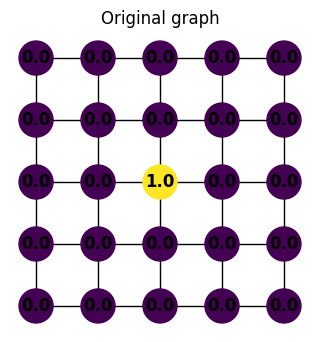

In [12]:
from torch_geometric.data import Data

#the height/width of the grid
size = 5
num_nodes = size * size

#we use utility function above to build the adjacency matrix in the COO format
edge_index = build_grid_graph(size)

# here the data variable will contain information about our graph
# (which is a Data structure)
data = Data(edge_index=edge_index)

# x contains a single binary feature with value 1 for the central node
data.x = torch.zeros((num_nodes, 1))

#manually labelling the central node
data.x[12, 0] = 1

title = 'Original graph'
plot_graph_with_colored_nodes(None, data, title, size)

We can then create a CustomModel class.

In [13]:
class CustomModel(torch.nn.Module):
    def __init__(self, input_dim, num_layers,
                 add_self_loops=False):
        super(CustomModel, self).__init__()
        self.num_layers = num_layers
        self.layers = torch.nn.ModuleList()
        self.layers.append(CustomLayer(input_dim, input_dim, add_self_loops))

        for _ in range(num_layers - 1):
            self.layers.append(CustomLayer(input_dim, input_dim, add_self_loops))

    def forward(self, x, edge_index):
        if self.num_layers == 0:
            return x
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
        x = self.layers[-1](x, edge_index)
        return x

And define the dimensionality of our model

In [14]:
# we consider an input dimension of one as each node is represented by one feature that is the color
input_dim = 1


We can now test the effect of different number of layers.

Do you think we can color the whole graph? If yes, how many layers do we need?

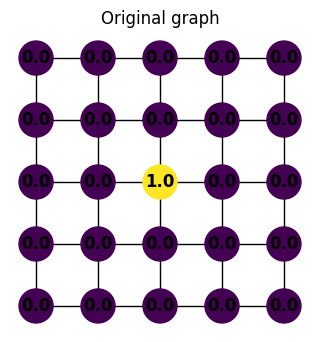

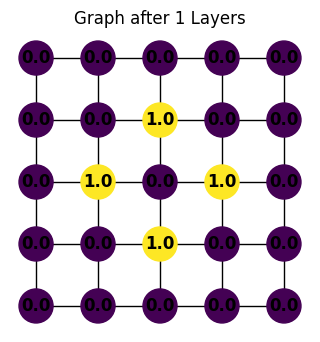

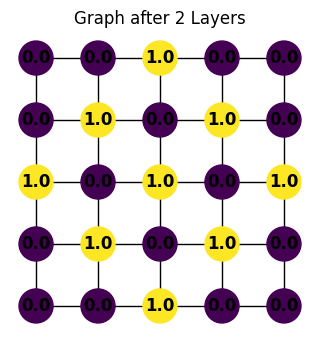

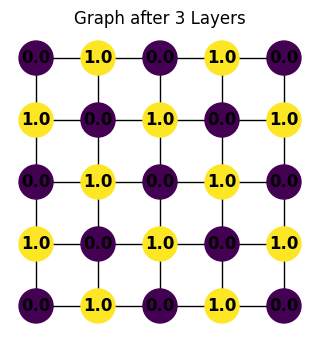

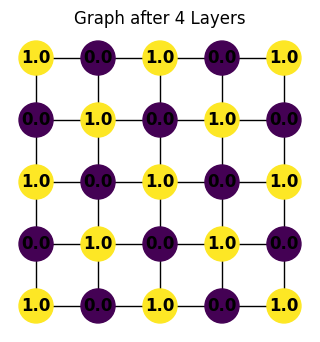

In [15]:
for num_layers in range(5):
    model = CustomModel(input_dim, num_layers)
    if num_layers == 0:
      title = 'Original graph'
    else:
      title = f'Graph after {num_layers} Layers'
    plot_graph_with_colored_nodes(model, data, title, size)

Notice what is happening: at each iteration, the nodes that are adjacent to a yellow node are being colored as we expected (the maximum value of the neighbours is 1). However, colored nodes are losing the information of their previous hidden state, and since all neighbours have a hidden state of 0 their new state is 0. Sometimes, like in this case, we need to combine the received message with the previous hidden state of the node. A common way to do this is to add a virtual edge between each node and itself, also called a "self loop".

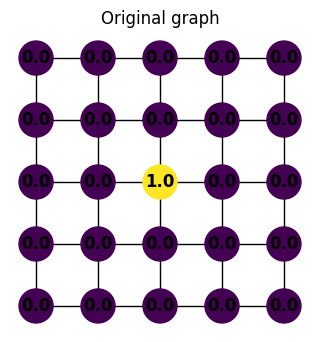

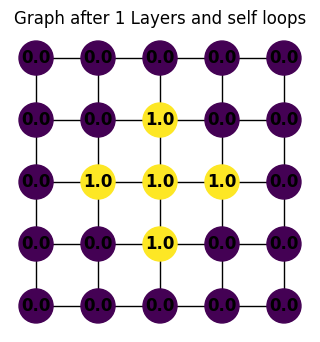

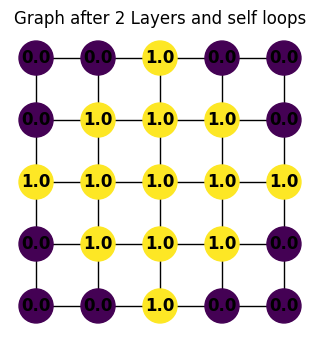

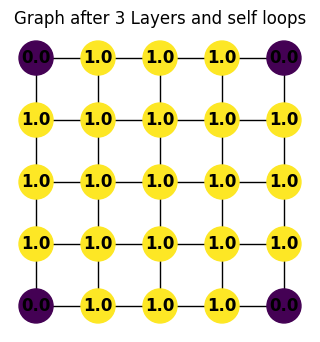

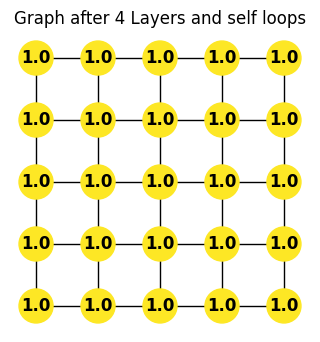

In [16]:
for num_layers in range(5):
    model = CustomModel(input_dim, num_layers,
                        add_self_loops=True)
    if num_layers == 0:
      title = 'Original graph'
    else:
      title = f'Graph after {num_layers} Layers and self loops'
    plot_graph_with_colored_nodes(model, data, title, size)

This simple example shows how a node in a graph can incorporate information from its surroundings using several iterations of message passing. The propagation of information is linked to the concept of "receptive field." This term describes the maximum distance for which a node is influenced by other nodes in the graph, a characteristic determined by the number of layers, also called depth. Through adjusting the model's depth, we can extend a node's ability to access and integrate distant information in the graph.

######**A more expressive message passing layer**

In most real-world applications, we will use layers that have more expressive $\mathrm{Aggregate}$ and $\mathrm{Update}$ functions. One of the first, and most known examples is the building block of the Graph Convolutional Network (GCN) proposed by (Kipf and Welling, 2016), which uses the following $\mathrm{Aggregate}$ function:

$\mathrm{Aggregate}(\{\boldsymbol h_m^{(l)}: m \in \mathcal N(n)\}) = \sum\limits_{m \in \mathcal N(n)}\frac{\boldsymbol h_m^{(l)}}{\sqrt{|\mathcal N(n)||\mathcal N(m)|}}$

The $\mathrm{Update}$ function is then:

$\mathrm{Update}(\boldsymbol h_n^{(l)}, \boldsymbol z^{(l)}) = \sigma^{(l)} \left( \boldsymbol W_\theta^{(l)} \boldsymbol z^{(l)} \right)$

Where $\boldsymbol W_\theta^{(l)}$ is a matrix of learnable parameters and $\sigma$ is an activation function, commonly $\mathrm{ReLU}$.

Such a layer is implemented in Pytorch Geometric as GCNConv [(reference)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html), with the main remark that the $\mathrm{Update}$ function does not include the non-linear activation $\sigma$, which is instead commonly added between layers in the forward method.

######**Creating the model**

##### **6.3 Implementation of GCN on the PROTEINS dataset**


GCN model is based on graph convolutions, which can be built by stacking multiple
convolutional layers, where "each layer followed by a point-wise non-linearity" [(reference: paper that introduced GCN)](https://arxiv.org/pdf/1609.02907.pdf)

We now implement a GCN model and train it on the PROTEINS dataset for a binary classification task, to predict whether the given protein (graph) is an enzyme.

So far, we have worked on a node level and there has been one output for each node. With the PROTEINS dataset we are performing a graph-level binary classification - whether the considered protein is an enzyme or not. For this reason, we need to somehow combine the final embeddings of the nodes into a vector the size of which does not depend on the number of nodes in the graph. This is done by introducing a third function in the message-passing framework, often called $\mathrm{Readout}$, such that:

$(3) \qquad \qquad \boldsymbol y = \mathrm{Readout}\left(\left\{ \boldsymbol h_n^{(L)} \; : \; n \in \mathcal V \right\}\right) $

$\mathrm{Readout}$ must be **differentiable** and **permutation invariant**, as the order in which the node embeddings are passed to the function should not change its output.

In this final example, we will use a global mean pooling function [(reference)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_mean_pool.html) as a readout function.

**TODO**: implement GCN model and train it on the PROTEINS dataset.

In [17]:
# adopted from MIT Copyright (c) 2023 PyG Team

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels_1, hidden_channels_2):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        # define the conv1, conv2, conv3, and a linear layers for the GCN
        # conv1 layer is a Graph Convolutional Layer, with in_channels as num_node_features and out_channels as hidden_channels_1
        # conv2 layer is a Graph Convolutional Layer, with in_channels as hidden_channels_1 and out_channels as hidden_channels_2
        # conv3 layer is a Graph Convolutional Layer, with in_channels as hidden_channels_2 and out_channels as hidden_channels_1
        # linear layer is a Linear layer with in_channels as hidden_channels_1 and out_channels as num_classes

        # write 4 lines of code
        # self.conv1 = ...
        # self.conv2 = ...
        # self.conv3 = ...
        # self.lin = ...
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels_1)
        self.conv2 = GCNConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GCNConv(hidden_channels_2, hidden_channels_1)
        self.lin = Linear(hidden_channels_1, dataset.num_classes)


    def forward(self, x, edge_index, batch):
        # perform a forward pass, using ReLU activation function after conv1 and conv2

        # Step 1: propagate signal in convolutional layers
        # Step 2: apply the global_mean_pool as a readout function
        # Step 3: add the dropout with p=0.5
        # Step 4: propagate signal in a linear layer

        # YOUR CODE HERE
        # raise NotImplementedError()
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels_1 = 32, hidden_channels_2 = 64)
print(model)

GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 64)
  (conv3): GCNConv(64, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


######**Training**

**TODO**: train the GCN model.

In [20]:
# Implement code for training and evaluating the GCN model above.
# You can re-use code from the previous labs
# Define the model, optimizer, and the criterion that could be used.
# Train the model for at least 50 epochs.
# For reference: state of the art performance on this dataset is 84.91 (accuracy).
# see https://paperswithcode.com/sota/graph-classification-on-proteins

# YOUR CODE HERE
# raise NotImplementedError()

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels_1 = 32, hidden_channels_2 = 64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 51):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.4900, Test Acc: 0.4625
Epoch: 002, Train Acc: 0.5900, Test Acc: 0.6053
Epoch: 003, Train Acc: 0.5900, Test Acc: 0.6053
Epoch: 004, Train Acc: 0.5900, Test Acc: 0.6053
Epoch: 005, Train Acc: 0.6071, Test Acc: 0.6174
Epoch: 006, Train Acc: 0.6357, Test Acc: 0.6392
Epoch: 007, Train Acc: 0.6614, Test Acc: 0.6489
Epoch: 008, Train Acc: 0.6543, Test Acc: 0.6441
Epoch: 009, Train Acc: 0.6714, Test Acc: 0.6513
Epoch: 010, Train Acc: 0.6643, Test Acc: 0.6513
Epoch: 011, Train Acc: 0.6686, Test Acc: 0.6538
Epoch: 012, Train Acc: 0.6700, Test Acc: 0.6586
Epoch: 013, Train Acc: 0.6557, Test Acc: 0.6368
Epoch: 014, Train Acc: 0.6529, Test Acc: 0.6320
Epoch: 015, Train Acc: 0.6600, Test Acc: 0.6538
Epoch: 016, Train Acc: 0.6657, Test Acc: 0.6562
Epoch: 017, Train Acc: 0.6514, Test Acc: 0.6344
Epoch: 018, Train Acc: 0.6614, Test Acc: 0.6538
Epoch: 019, Train Acc: 0.6671, Test Acc: 0.6634
Epoch: 020, Train Acc: 0.6457, Test Acc: 0.6416
Epoch: 021, Train Acc: 0.6529, Test Acc: